In [1]:
## Script Index: S8
## Author: Liu Yue
## Date: 13/10/2016
## Python Version: Anaconda 4.2.0, python 3.5


"""
    This script runs feature selections from 511 subsets 
    CAUTION: It takes a long time for running this script
"""


""" Load and describe dataset"""
import csv
import copy
import math
## Read device_model_details
with open('S6_device model details.csv', newline='',encoding='utf-8') as f:
    file = csv.reader(f)
    device_model_details = list(file)
    
for line in device_model_details:
    numeric_index = {1,2,3,4,5,6,7,8,9,12,13}
    for i in numeric_index:
        line[i] = float(line[i])
        if int(str(line[i]).split('.')[1])==0:
            line[i] = int(line[i])
lst = device_model_details

lst2 =  copy.deepcopy(lst)
total_device_count = sum(line[12] for line in lst2)
print("Total number of devices for all device models:",total_device_count)
total_app_device_count = sum(line[13] for line in lst2)
print("Total number of devices with selected app installed:",total_app_device_count)
standard_rate = total_app_device_count/total_device_count
print("Weighted average installation rate:", round(standard_rate,3))

Total number of devices for all device models: 56865
Total number of devices with selected app installed: 38291
Weighted average installation rate: 0.673


In [2]:
""" Obtain the superset of attributes"""
from itertools import combinations, chain
allsubsets = lambda n: list(chain(*[combinations(range(n), ni) for ni in range(n+1)]))
all_subsets = sorted(allsubsets(9), key=lambda line:len(line), reverse=True)

In [3]:
""" Methods """
import math
import heapq
from scipy import spatial

def merge_device_models(lst):
    """ Method to check device models with the same attributes and merge"""
    for line in lst:
        device_model_name = line[0]
        for line2 in lst:
            device_model_name2 = line2[0]
            if device_model_name!=device_model_name2 and line[1]==line2[1]:
                line[0] = device_model_name + device_model_name2
                line[2] = [line[2][0]+line2[2][0], line[2][1]+line2[2][1]]
                lst.remove(line2)
    lst = sorted(lst, key=lambda line:line[2][0],reverse=True) 

def append_installation_rate(lst):
    """ Method to add average and actual installation rate"""
    for line in lst:
        installation_rate = line[2][1]/line[2][0]
        line.append([round(standard_rate,3),round(installation_rate,3)])
        
def rmse_using_average(lst):
    squared_error_average = 0
    for line in lst:
        average = line[3][0]
        actual = line[3][1]
        squared_error_average += (average-actual)*(average-actual)
    return(math.sqrt(squared_error_average/len(lst)))

def similarity_computation(lst):
    """ Compute all similarity for all divice models """
    sim_mat = []
    for line in lst:
        sim_line = []
        for line2 in lst:
            sim = 1 - spatial.distance.cosine(line[1], line2[1])
            sim_line.append(sim)
        sim_mat.append(sim_line)
    return(sim_mat)

def rmse_calculation(lst, prediction_index):
    """ Method to check the prediction error """
    count = 0
    squared_error_prediction = 0
    for line in lst:
        average = line[3][0]
        actual = line[3][1]
        prediction = line[3][prediction_index+2]
        squared_error_prediction += (prediction-actual)*(prediction-actual)
        if abs(prediction-actual) < abs(average-actual):
            count+=1
    return(math.sqrt(squared_error_prediction/len(lst)))

def rmse_different_n(lst,sim_mat,attribute_set):
    prediction_index = 0
    rmse_lst = [[],[],rmse_using_average(lst),attribute_set]
    for sim_n in range(1,30):   # use top N similar device model
        """ Find top n similarity """
        sim_val = [heapq.nlargest(sim_n+1, line) for line in sim_mat]
        sim_val = [line[1:] for line in sim_val]

        ## Get assignmed index of top N similar device model
        sim_name = []
        for i in range(0, len(sim_val)):
            sim_name.append([lst3[k][0] for k, j in enumerate(sim_mat[i]) if j in sim_val[i]])

        for i in range(0, len(lst)):
            line = lst[i]
            names = sim_name[i]
            vals = sim_val[i]
            id_count_sum = 0
            id_count_with_app = 0
            for line2 in lst:       
                if line2[0] in names:            
                    id_count_sum += line2[2][0]
                    id_count_with_app += line2[2][1]
            line[3].append(round(id_count_with_app/id_count_sum,3))    
        rmse = rmse_calculation(lst, prediction_index)
        prediction_index+=1
        rmse_lst[0].append(sim_n)
        rmse_lst[1].append(rmse)        
    return(rmse_lst)

def rmse_min_calculation(rmse_lst):
    """ Method to find the minimum rmse for each attribute set"""
    rmse = rmse_lst[1]
    rmse_min = round(min(rmse),3)
    n = rmse_lst[0]
    n_rmse_min = [n[i] for i, j in enumerate(rmse) if j == min(rmse)]
    #print("while RMSE using average prediction rate is",rmse_lst[2], "Minimum RMSE is",rmse_min,"when N is",n_rmse_min) 
    return([round(rmse_lst[2],3),rmse_min,n_rmse_min])

def rmse_plot(rmse_lst,attribute_set):
    """ Method to plot rmse against N"""
    rmse = rmse_lst[1]
    n = rmse_lst[0]
    legend.append(attribute_set)
    plt.plot(n, rmse)    

In [55]:
""" Select among attributes """
attribute_selection = 0
attribute_set = all_subsets[attribute_selection]
lst3 = [[line[10:12]]+[[line[i+1] for i in attribute_set]]+[line[12:14]] for line in lst2]
lst3 = sorted(lst3, key=lambda line:line[2][0],reverse=True)

merge_device_models(lst3)
append_installation_rate(lst3)
sim_mat = similarity_computation(lst3)
rmse_lst = rmse_different_n(lst3,sim_mat,attribute_set)

line = rmse_min_calculation(rmse_lst)
line.append(len(lst3))
line.append(attribute_set)
print("RMSE drops from .. to .. by predction using most similar .. device models, .. total device models for ... attributs selected")
print(line)

RMSE drops from .. to .. by predction using most similar .. device models, .. total device models for ... attributs selected
[0.364, 0.296, [6], 842, (0, 1, 2, 3, 4, 5, 6, 7, 8)]


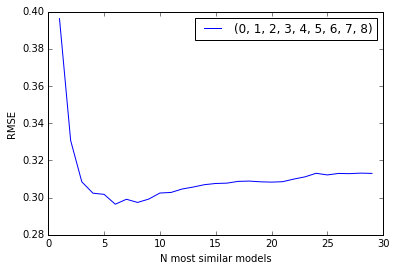

In [58]:
"""plot RMSE vs N device models selected (k in KNN) for all features"""
import matplotlib.pyplot as plt
%matplotlib inline
plt.ylabel('RMSE')
plt.xlabel('N most similar models')
legend = []

rmse_plot(rmse_lst,attribute_set)

plt.legend(legend, loc='upper right')
plt.show()

In [11]:
""" Iterate for all attribute_set """
results = []
for attribute_selection in range(0,len(all_subsets)-1):
    attribute_set = all_subsets[attribute_selection]
    lst3 = [[line[10:12]]+[[line[i+1] for i in attribute_set]]+[line[12:14]] for line in lst2]
    lst3 = sorted(lst3, key=lambda line:line[2][0],reverse=True)

    merge_device_models(lst3)
    append_installation_rate(lst3)
    sim_mat = similarity_computation(lst3)
    rmse_lst = rmse_different_n(lst3,sim_mat,attribute_set)

    line = rmse_min_calculation(rmse_lst)
    line.append(len(lst3))
    line.append(attribute_set)
    
    results.append(line)

C:\Anaconda3\lib\site-packages\scipy\spatial\distance.py:326: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - np.dot(u, v) / (norm(u) * norm(v))
C:\Anaconda3\lib\site-packages\scipy\spatial\distance.py:326: RuntimeWarning: invalid value encountered in true_divide
  dist = 1.0 - np.dot(u, v) / (norm(u) * norm(v))


In [33]:
def rmse_min_fix_number_attributes(results,n):
    rmse_min_possible = min([line[1] for line in results if len(line[4])==n])
    print("\nWith", n, "attributes")
    for line in results:
        if len(line[4])==n and rmse_min_possible==line[1]:
            print(line)
for i in range(1,10):
    rmse_min_fix_number_attributes(results,i)


With 1 attributes
[0.248, 0.27, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 11, (4,)]

With 2 attributes
[0.331, 0.248, [18], 203, (5, 7)]

With 3 attributes
[0.314, 0.235, [8], 194, (0, 3, 5)]

With 4 attributes
[0.309, 0.233, [7], 243, (0, 3, 4, 5)]

With 5 attributes
[0.312, 0.248, [12], 318, (0, 1, 3, 4, 5)]

With 6 attributes
[0.331, 0.27, [10], 414, (0, 1, 2, 3, 4, 5)]

With 7 attributes
[0.358, 0.287, [14], 743, (0, 1, 2, 3, 4, 5, 7)]
[0.361, 0.287, [9], 792, (0, 1, 2, 3, 5, 6, 7)]
[0.358, 0.287, [8], 781, (1, 2, 3, 4, 5, 6, 7)]

With 8 attributes
[0.362, 0.29, [9], 798, (0, 1, 2, 3, 4, 5, 6, 7)]

With 9 attributes
[0.364, 0.296, [6], 842, (0, 1, 2, 3, 4, 5, 6, 7, 8)]


In [ ]:
"""Conclusion
With 3 attributes
[0.314, 0.235, [8], 194, (0, 3, 5)]

With 4 attributes
[0.309, 0.233, [7], 243, (0, 3, 4, 5)]

The arrtibutes are SCREEN SIZE, FRONT CAMERA, #CORE, RAM
"""